In [93]:
from skimage import io
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn.decomposition import PCA
from skimage.transform import SimilarityTransform
from skimage.transform import warp
import os
import pathlib
import random

## Preprocessing data for machine learning
The photos contains cats in many situations and backgrounds. To make it easier to do machine learning, we will preprocess the data, so the photos only contains the face of the cat. Preprocessing is and important step in most machine learning approaches.

In [2]:
def read_landmark_file(file_name):
    f = open(file_name, 'r')
    lm_s = f.readline().strip().split(' ')
    #print(lm_s)
    n_lms = int(lm_s[0])
    if n_lms < 3:
        print(f"Not enough landmarks found")
        return None

    new_lms = 3
    # 3 landmarks each with (x,y)
    lm = np.zeros((new_lms, 2))
    for i in range(new_lms):
        lm[i, 0] = lm_s[1 + i * 2]
        lm[i, 1] = lm_s[2 + i * 2]
    return lm

In [3]:
def align_and_crop_one_cat_to_destination_cat(img_src, lm_src, img_dst, lm_dst):
    """
    Landmark based alignment of one cat image to a destination
    :param img_src: Image of source cat
    :param lm_src: Landmarks for source cat
    :param lm_dst: Landmarks for destination cat
    :return: Warped and cropped source image. None if something did not work
    """
    tform = SimilarityTransform()
    tform.estimate(lm_src, lm_dst)
    warped = warp(img_src, tform.inverse, output_shape=img_dst.shape)

    # Center of crop region
    cy = 185
    cx = 210
    # half the size of the crop box
    sz = 180
    warp_crop = warped[cy - sz:cy + sz, cx - sz:cx + sz]
    shape = warp_crop.shape
    if shape[0] == sz * 2 and shape[1] == sz * 2:
        return img_as_ubyte(warp_crop)
    else:
        print(f"Could not crop image. It has shape {shape}. Probably to close to border of image")
        return None

In [4]:
def preprocess_all_cats(in_dir, out_dir):
    """
    Create aligned and cropped version of image
    :param in_dir: Where are the original photos and landmark files
    :param out_dir: Where should the preprocessed files be placed
    """
    dst = "ModelCat/ModelCat"
    dst_lm = read_landmark_file(f"{dst}.jpg.cat")
    dst_img = io.imread(f"{dst}.jpg")

    all_images = glob.glob(in_dir + "*.jpg")
    for img_idx in all_images:
        name_no_ext = os.path.splitext(img_idx)[0]
        base_name = os.path.basename(name_no_ext)
        out_name = f"{out_dir}/{base_name}_preprocessed.jpg"

        src_lm = read_landmark_file(f"{name_no_ext}.jpg.cat")
        src_img = io.imread(f"{name_no_ext}.jpg")

        proc_img = align_and_crop_one_cat_to_destination_cat(src_img, src_lm, dst_img, dst_lm)
        if proc_img is not None:
            io.imsave(out_name, proc_img)

In [5]:
in_dir = 'training_data/'
out_dir = 'preprocessed_training_data/'

preprocess_all_cats(in_dir, out_dir)

## Gathering data into a data matrix
To start, we want to collect all the image data into a data matrix. The matrix should have dimensions [n_samples, n_features] where n_samples is the number of photos in our training set and n_features is the number of values per image. Since we are working with RGB images, the number of features are given by n_features = height * width * channels, where channels = 3.

Find the number of image files in the preprocessed folder using glob. Look at the preprocess_all_cats function to get an idea of how to use glob.

In [6]:
preprocess_images = glob.glob(out_dir + "*.jpg")
number_files = len(preprocess_images)

Read the first photo and use that to find the height and width of the photos

In [7]:
first_img = io.imread(preprocess_images[0])
height = first_img.shape[0]
width = first_img.shape[1]

Set n_samples and n_features

In [8]:
n_samples = number_files
n_features = height*width*3

Make an empty matrix data_matrix = np.zeros((n_samples, n_features))

In [9]:
data_matrix = np.zeros((n_samples, n_features))

Read the image files one by one and use flatten() to make each image into a 1-D vector (flat_img).

Put the image vector (flat_img) into the data matrix by for example data_matrix[idx, :] = flat_img , where idx is the index of the current image.

In [10]:
for idx in range(0,n_samples):
    flat_img = io.imread(preprocess_images[idx]).flatten()
    data_matrix[idx,:] = flat_img

## Compute and visualize a mean cat
In the data matrix, one row is one cat. You can therefore compute an average cat, The Mean Cat by computing one row, where each element is the average of the column.

In [11]:
avg_cat = data_matrix.mean(axis=0)

You can use the supplied function create_u_byte_image_from_vector to create an image from a 1-D image vector.

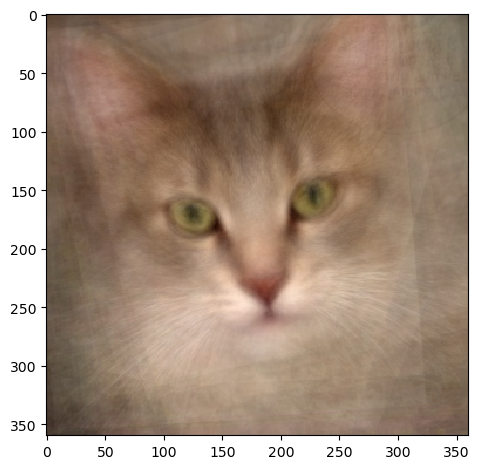

In [12]:
def create_u_byte_image_from_vector(im_vec, height, width, channels):
    min_val = im_vec.min()
    max_val = im_vec.max()

    # Transform to [0, 1]
    im_vec = np.subtract(im_vec, min_val)
    im_vec = np.divide(im_vec, max_val - min_val)
    im_vec = im_vec.reshape(height, width, channels)
    im_out = img_as_ubyte(im_vec)
    return im_out

io.imshow(create_u_byte_image_from_vector(avg_cat, height, width, 3))

## Find a missing cat or a cat that looks like it (using image comparison)
You have promised to take care of your neighbours cat while they are on vacation. But...Oh! no! You were in such a hurry to get to DTU that you forgot to close a window. Now the cat is gone!!! What to do?

Use the preprocess_one_cat function to preprocess the photo of the poor missing cat

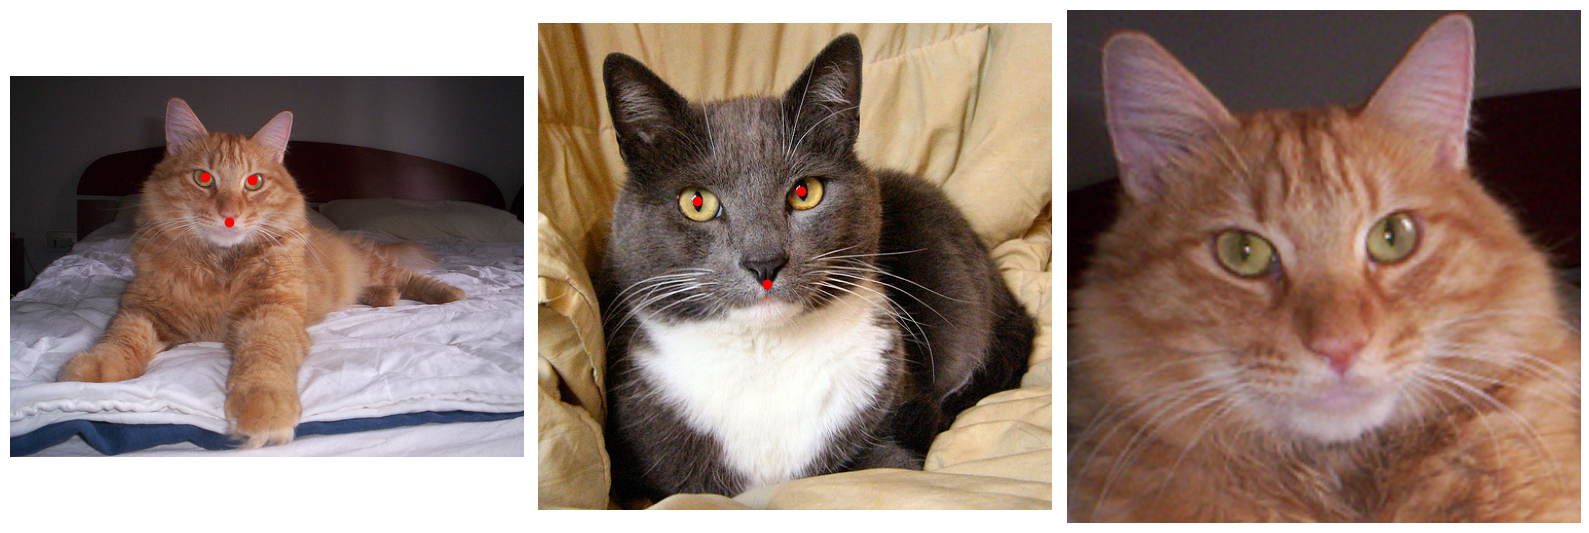

In [13]:
def preprocess_one_cat():
    src = "MissingCat/MissingCat"
    dst = "ModelCat/ModelCat"
    out = "MissingCatProcessed.jpg"

    src_lm = read_landmark_file(f"{src}.jpg.cat")
    dst_lm = read_landmark_file(f"{dst}.jpg.cat")

    src_img = io.imread(f"{src}.jpg")
    dst_img = io.imread(f"{dst}.jpg")

    src_proc = align_and_crop_one_cat_to_destination_cat(src_img, src_lm, dst_img, dst_lm)
    if src_proc is None:
        return

    io.imsave(out, src_proc)

    fig, ax = plt.subplots(ncols=3, figsize=(16, 6))
    ax[0].imshow(src_img)
    ax[0].plot(src_lm[:, 0], src_lm[:, 1], '.r', markersize=12)
    ax[1].imshow(dst_img)
    ax[1].plot(dst_lm[:, 0], dst_lm[:, 1], '.r', markersize=12)
    ax[2].imshow(src_proc)
    for a in ax:
        a.axis('off')
    plt.tight_layout()
    plt.show()

preprocess_one_cat()

Flatten the pixel values of the missing cat so it becomes a vector of values.

In [14]:
missing_img = io.imread('MissingCatProcessed.jpg')
flat_missing_img = missing_img.flatten()

Subtract you missing cat data from all the rows in the data_matrix and for each row compute the sum of squared differences. This can for example be done by:

In [23]:
sub_data = data_matrix - flat_missing_img
sub_distances = np.linalg.norm(sub_data, axis=1)


Find the cat that looks most like your missing cat by finding the cat, where the SSD is smallest. You can for example use np.argmin.

In [24]:
index_min = np.argmin(sub_distances)

Extract the found cat from the data_matrix and use create_u_byte_image_from_vector to create an image that can be visualized. Did you find a good replacement cat? Do you think your neighbour will notice? Even with their glasses on?

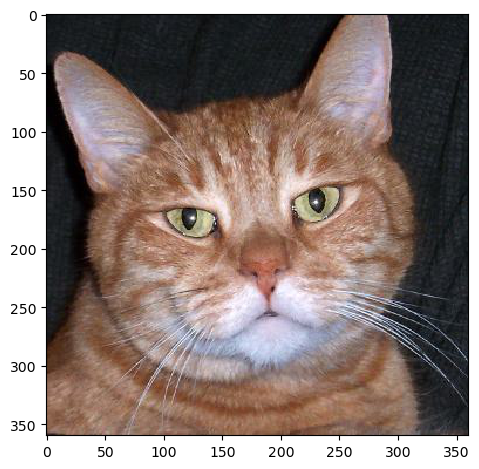

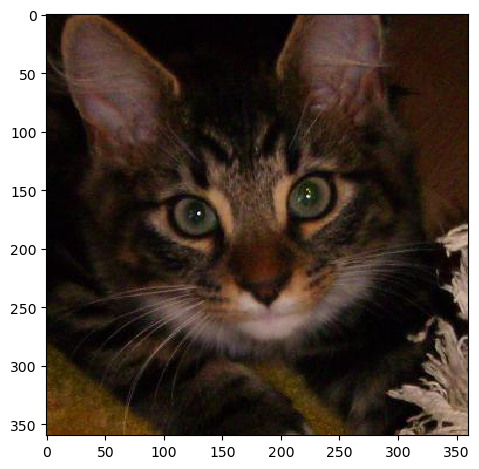

In [26]:
io.imshow(create_u_byte_image_from_vector(io.imread(preprocess_images[index_min]), height, width, 3))

You can use np.argmax to find the cat that looks the least like the missing cat.

## Principal component analysis on the cats
We now move to more classical machine learning on cats. Namely Principal component analysis (PCA) analysis of the cats image.

To compute the PCA, we use the sci-kit learn PCA. Not that this version of PCA automatically centers data. It means that it will subtract the average cat from all cats for you.

Start by computing the first 50 principal components:

In [27]:
print("Computing PCA")
cats_pca = PCA(n_components=50)
cats_pca.fit(data_matrix)

Computing PCA


PCA(n_components=50)

Plot the amount of the total variation explained by each component as function of the component number.

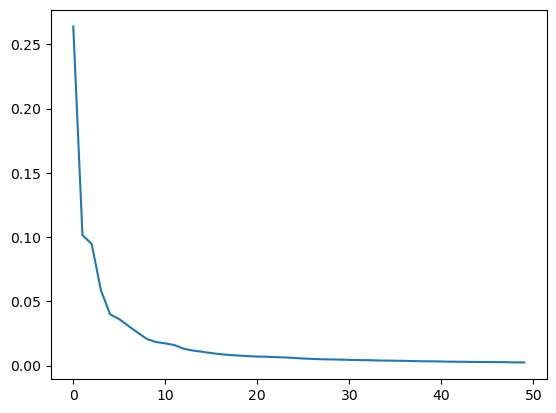

In [33]:
plt.plot(cats_pca.explained_variance_ratio_)

How much of the total variation is explained by the first component?

In [30]:
print(cats_pca.explained_variance_ratio_[0])

0.26384542774182573


Project the cat images into PCA space:

In [31]:
components = cats_pca.transform(data_matrix)

We can plot the first two dimensions of the PCA space, to see where the cats are placed.

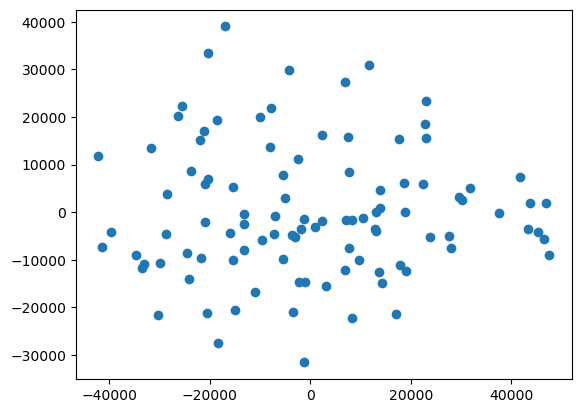

In [35]:
pc_1 = components[:, 0]
pc_2 = components[:, 1]

plt.scatter(pc_1, pc_2)

## Cats in space
We would like to explore what the PCA learnt about our cats in the data set.

Use np.argmin and np.argmax to find the ids of the cats that have extreme values in the first and second PCA coordinates. Extract the cats data from the data matrix and use create_u_byte_image_from_vector to visualize these cats.

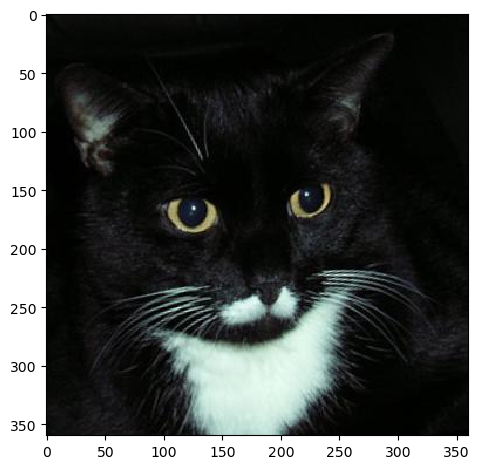

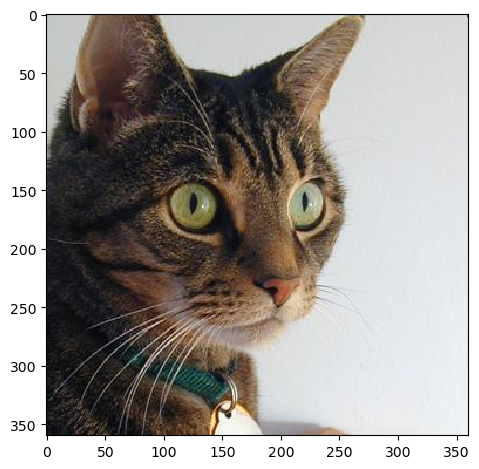

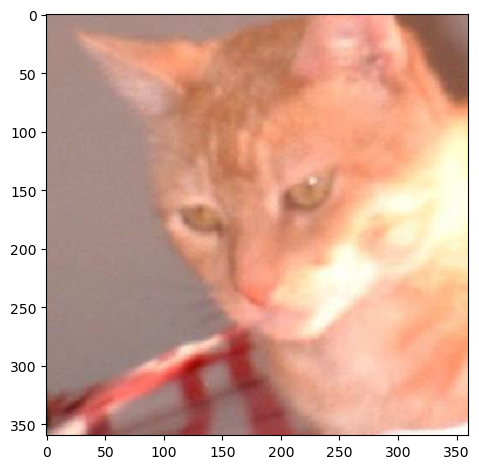

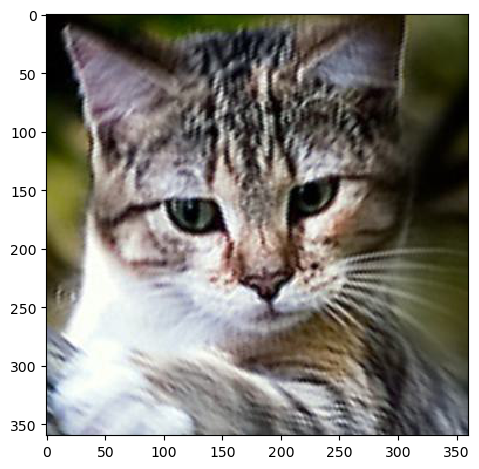

In [40]:
ext_min_pc1 = np.argmin(pc_1)
ext_min_pc2 = np.argmin(pc_2)

ext_max_pc1 = np.argmax(pc_1)
ext_max_pc2 = np.argmax(pc_2)

display_list = [ext_max_pc1, ext_max_pc2, ext_min_pc1, ext_min_pc2]

for ext in display_list:
    io.imshow(create_u_byte_image_from_vector(io.imread(preprocess_images[ext]), height, width, 3))
    io.show()

Also plot the PCA space where you plot the extreme cats with another marker and color.

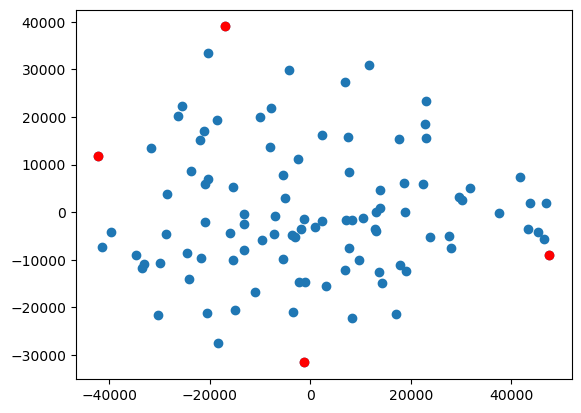

In [42]:
plt.scatter(pc_1, pc_2)
for ext in display_list:
    plt.scatter(pc_1[ext],pc_2[ext], color='r')

## The first synthesized cat
We can use the PCA to make a so-called generative model that can create synthetic samples from the learnt data. It is done by adding a linear combination of principal components to the average cat image:

In [70]:
synth_cat = avg_cat + 69999 * cats_pca.components_[0, :]

Use create_u_byte_image_from_vector visualize your fake cat.

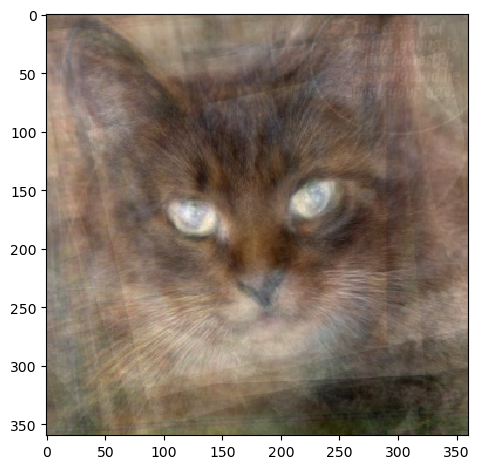

In [71]:
io.imshow(create_u_byte_image_from_vector(synth_cat, height, width, 3))

You can use the PCA plot we did before to select some suitable values for w.

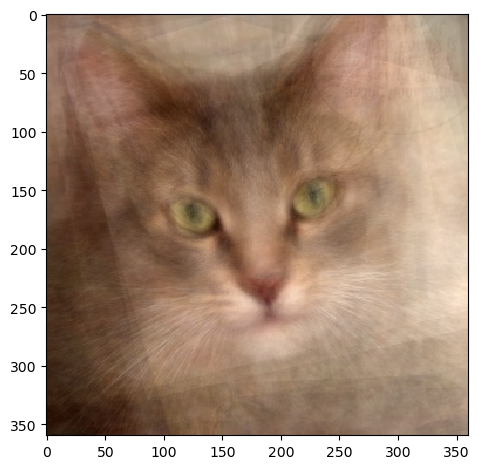

In [81]:
synth_cat = avg_cat + 3999 * cats_pca.components_[0, :] + 9099 * cats_pca.components_[1, :]
io.imshow(create_u_byte_image_from_vector(synth_cat, height, width, 3))

## The major cat variation in the data set
A very useful method to get an overview of the major modes of variation in a dataset is to synthesize the samples that are lying on the outer edges of the PCA space.

If we for example move a distance out of the first principal axis we can synthesize the cat image there. In this case we will try to move to 
, where explained variance is the variance explained by that principal component. In code, this will look like

Synthesize and visualize cats that demonstrate the first three major modes of variation. Try show the average cat in the middle of a plot, with the negative sample to the left and the positive to the right. Can you recognise some visual patterns in these modes of variation?

In [84]:
m = 3

synth_cat_plus = avg_cat + 3 * np.sqrt(cats_pca.explained_variance_[m]) * cats_pca.components_[m, :]
synth_cat_minus = avg_cat - 3 * np.sqrt(cats_pca.explained_variance_[m]) * cats_pca.components_[m, :]

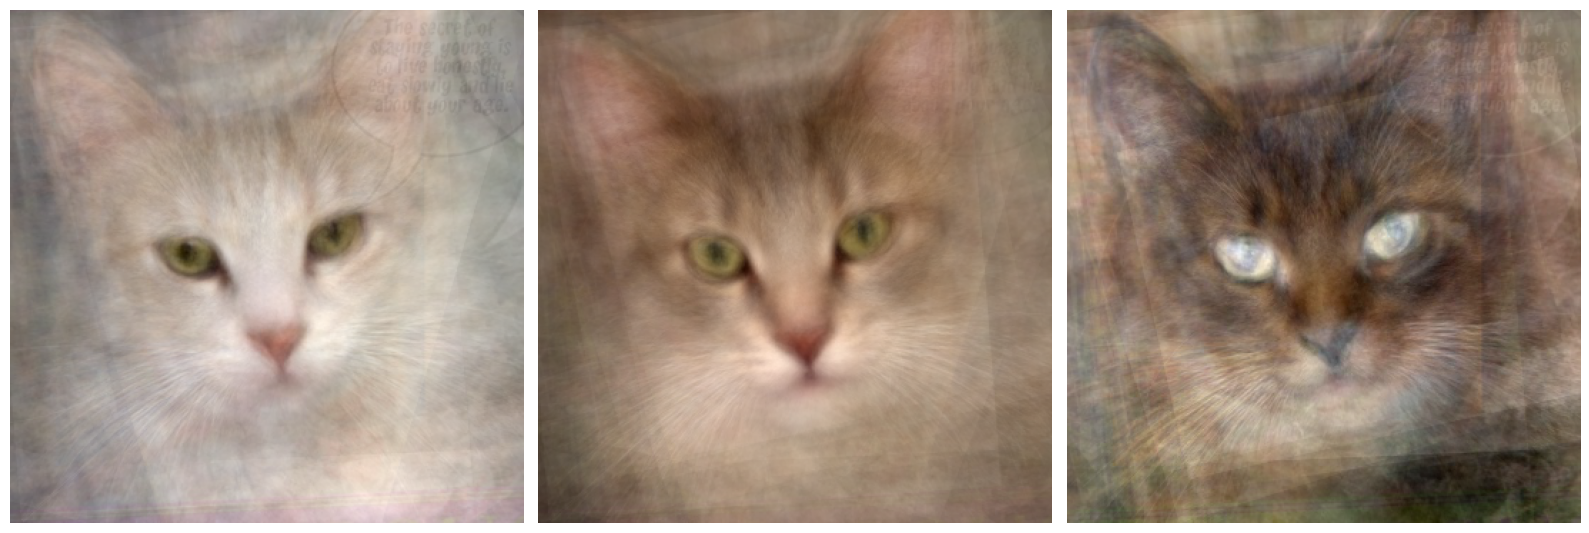

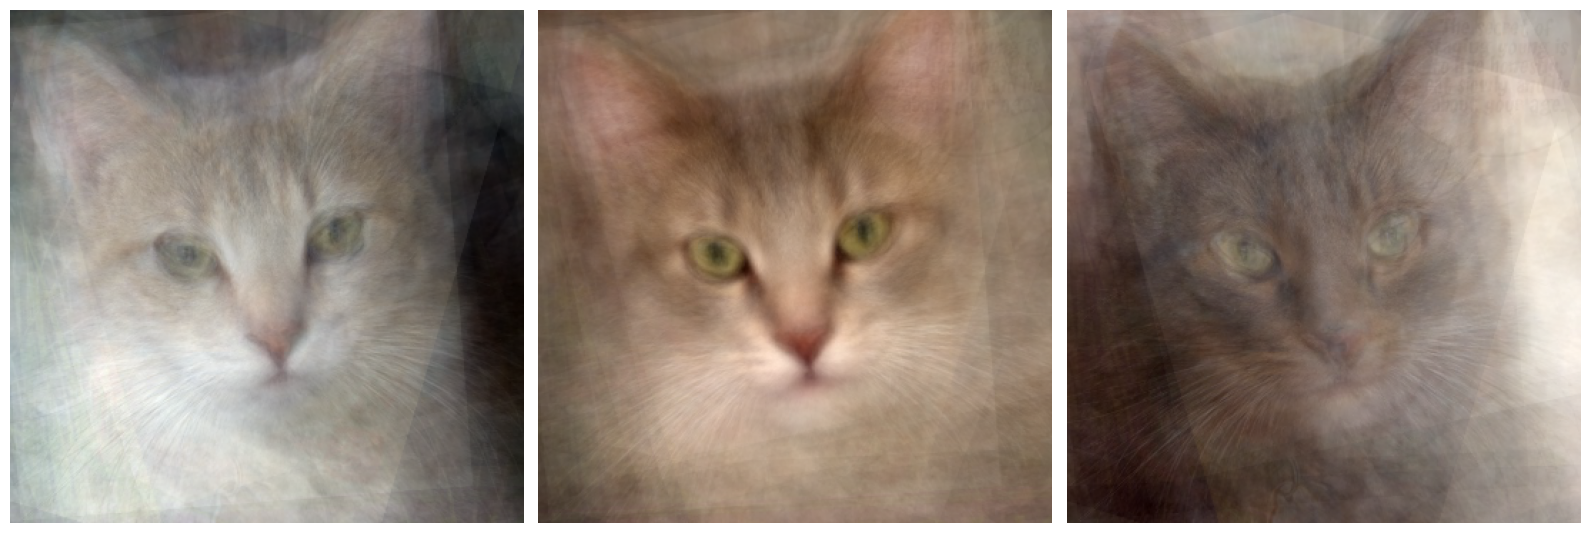

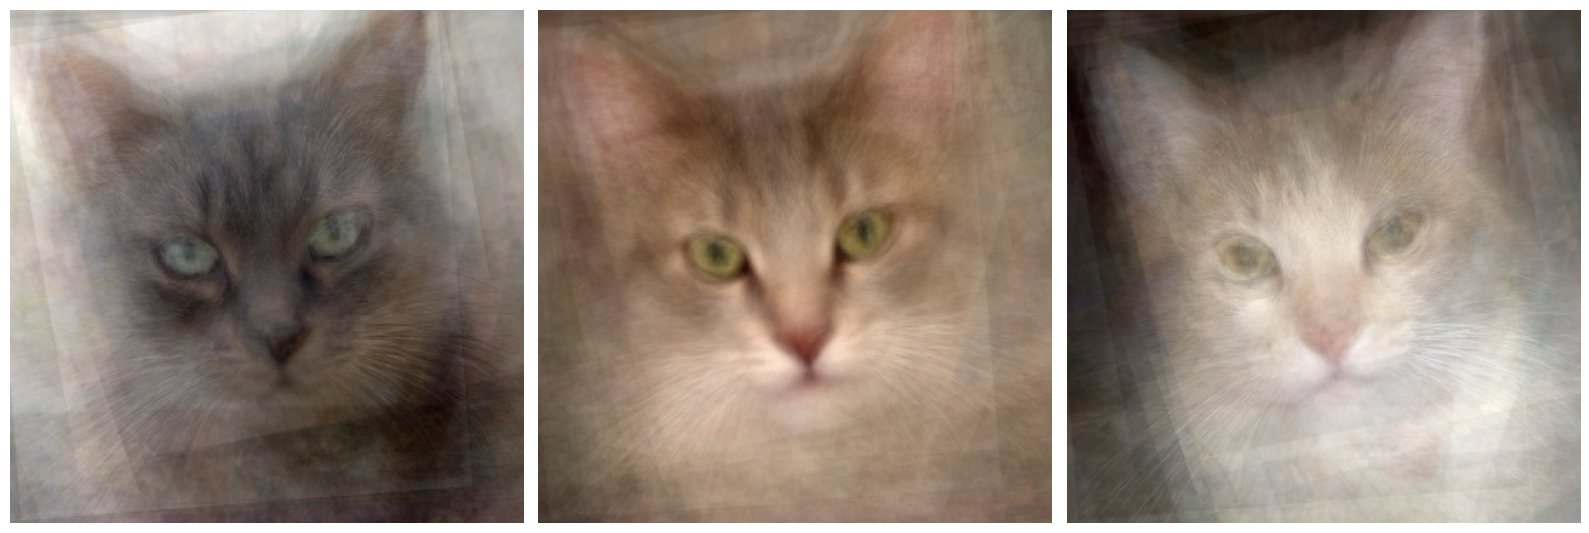

In [90]:
for m in range(3):
    synth_cat_plus = avg_cat + 3 * np.sqrt(cats_pca.explained_variance_[m]) * cats_pca.components_[m, :]
    synth_cat_minus = avg_cat - 3 * np.sqrt(cats_pca.explained_variance_[m]) * cats_pca.components_[m, :]
    
    fig, ax = plt.subplots(ncols=3, figsize=(16, 6))
    ax[0].imshow(create_u_byte_image_from_vector(synth_cat_minus, height, width, 3))
    ax[1].imshow(create_u_byte_image_from_vector(avg_cat, height, width, 3))
    ax[2].imshow(create_u_byte_image_from_vector(synth_cat_plus, height, width, 3))
    for a in ax:
        a.axis('off')
    plt.tight_layout()
    plt.show()

## The Cat Synthesizer (EigenCats)
We are now ready to make true cat synthesizer, where cat images are synthesized based on random locations in PCA space. You can start by setting your synth_cat = average_cat. Then you can add all the components you want by for example (this number should be less or equal to the number of components we asked the PCA to compute):

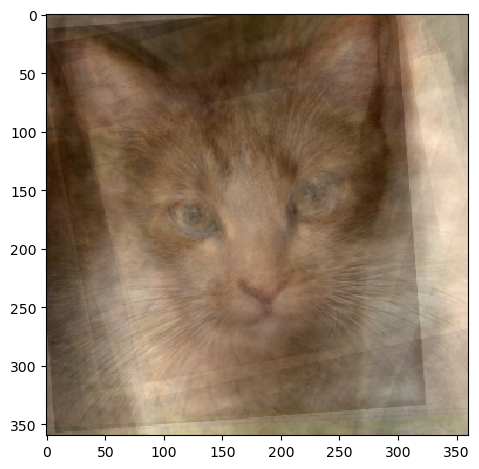

In [103]:
n_components_to_use = 10
synth_cat = avg_cat
for idx in range(n_components_to_use):
	w = random.uniform(-1, 1) * 3 * np.sqrt(cats_pca.explained_variance_[idx])
	synth_cat = synth_cat + w * cats_pca.components_[idx, :]
io.imshow(create_u_byte_image_from_vector(synth_cat, height, width, 3))

## Cat identification in PCA space
Now back to your missing cat. We could find similar cats by computing the difference between the missing cat and all the photos in the databased. Imagine that you only needed to store the 50 weights per cats in your database to do the same type of identification?

Start by finding the PCA space coordinates of your missing cat:

In [105]:
im_miss = io.imread("MissingCatProcessed.jpg")
im_miss_flat = im_miss.flatten()
im_miss_flat = im_miss_flat.reshape(1, -1)
pca_coords = cats_pca.transform(im_miss_flat)
pca_coords = pca_coords.flatten()

Plot all the cats in PCA space using the first two dimensions. Plot your missing cat in the same plot, with another color and marker. Is it placed somewhere sensible and does it have close neighbours?

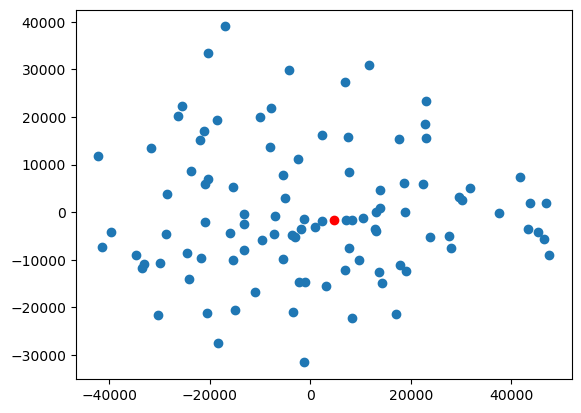

In [106]:
plt.scatter(pc_1, pc_2)
plt.scatter(pca_coords[0],pca_coords[1], color='r')

We can generate the synthetic cat that is the closest to your missing cat, by using the missing cats position in PCA space:

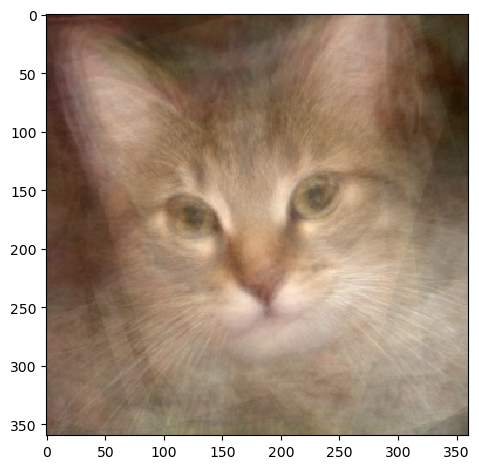

In [115]:
n_components_to_use = 17
synth_cat = avg_cat
for idx in range(n_components_to_use):
	synth_cat = synth_cat + pca_coords[idx] * cats_pca.components_[idx, :]
io.imshow(create_u_byte_image_from_vector(synth_cat, height, width, 3))

We can compute Euclidean distances in PCA space between your cat and all the other cats by:



In [116]:
comp_sub = components - pca_coords
pca_distances = np.linalg.norm(comp_sub, axis=1)

You can also find the n closest cats by using the np.argpartition function. Find the ids of and visualize the 5 closest cats in PCA space. Do they look like your cat?

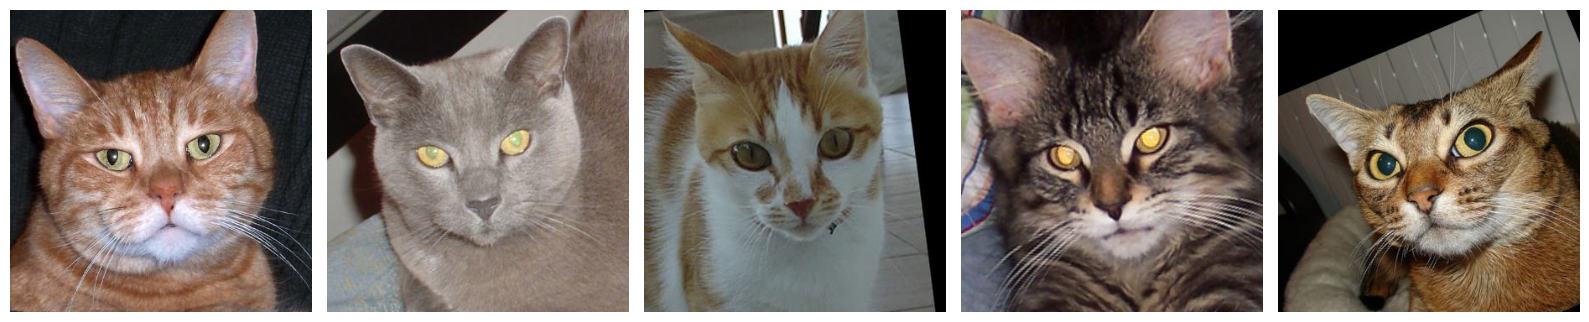

In [121]:
indexs = np.argpartition(pca_distances, 3)[:5]
fig, ax = plt.subplots(ncols=5, figsize=(16, 6))

for index,i in zip(indexs,range(0,5)):
    ax[i].imshow(create_u_byte_image_from_vector(io.imread(preprocess_images[index]), height, width, 3))

for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()